# Deep Q-learning (DQL) or Deep Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size, action_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    actions_logits = tf.placeholder(tf.float32, [None, action_size], name='actions_logits')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, actions_logits, states, next_states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [13]:
# Generator/Autorencoder/Adv
def G(states, actions_logits, state_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('G', reuse=reuse):
        # First fully connected layer
        h1 = mlp(inputs=states, units=hidden_size)
        h1 = bn(inputs=h1, training=is_training)
        h1 = nl(h1)
        print(states.shape, h1.shape)
        
        # Second fully connected layer
        h2 = tf.concat([h1, actions_logits], axis=1)
        h2 = mlp(inputs=h2, units=hidden_size)
        #h2 += h1
        h2 = bn(inputs=h2, training=is_training)
        h2 = nl(h2)
        print(h2.shape)
        
        # Output layer
        next_states_ = mlp(inputs=h2, units=state_size)
        return next_states_

In [14]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h1 = mlp(inputs=states, units=hidden_size)
        h1 = bn(inputs=h1, training=is_training)
        h1 = nl(h1)
        print(states.shape, h1.shape)
        
        # Second fully connected layer
        h2 = mlp(inputs=h1, units=hidden_size)
        #h2 += h1
        h2 = bn(inputs=h2, training=is_training)
        h2 = nl(h2)
        print(h2.shape)
        
        # Output layer
        actions_ = mlp(inputs=h2, units=action_size)
        return actions_

In [15]:
def model_loss(actions, actions_logits, states, next_states, targetQs, 
               state_size, action_size, hidden_size, 
               is_training=False):

    next_states_ = G(states=states, actions_logits=actions_logits, hidden_size=hidden_size, 
                     state_size=state_size, is_training=is_training)
    
    gloss = tf.reduce_mean(tf.reduce_sum((next_states - next_states_)**2, axis=1))

    actions_logits_ = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                        is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits_.dtype)
    
    Qs = tf.reduce_max(actions_logits_ * actions_labels, axis=1)
    
    dloss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits_, next_states_, gloss, dloss

In [16]:
def model_opt(gloss, dloss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('G')]
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(gloss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(dloss, var_list=d_vars)

    return g_opt, d_opt

In [17]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        (self.actions, self.actions_logits, self.states, self.next_states, self.targetQs, \
         self.is_training) = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits_, self.next_states_, self.gloss, self.dloss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, next_states=self.next_states, 
            actions=self.actions, actions_logits=self.actions_logits,
            targetQs=self.targetQs, is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(gloss=self.gloss, dloss=self.dloss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [18]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [20]:
# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-04         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20             # experience mini-batch size
gamma = 0.99                 # future reward discount

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [22]:
# state = env.reset()

# for _ in range(memory_size):
    
#     action = env.action_space.sample()
    
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [23]:
def learn(sess, memory, batch_size):
    
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    actions_logits = np.array([each[5] for each in batch])
    
    next_actions_logits_ = sess.run(model.actions_logits_, feed_dict = {model.states: next_states, 
                                                                        model.is_training: False})
    
    nextQs = np.max(next_actions_logits_, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    feed_dict = {model.states: states, model.actions: actions, model.actions_logits: actions_logits,
                 model.next_states: next_states, model.targetQs: targetQs, model.is_training: False}
    
    dloss, _ = sess.run([model.dloss, model.d_opt], feed_dict)
    gloss, _ = sess.run([model.gloss, model.g_opt], feed_dict)
                                                             
    return gloss, dloss

In [24]:
def env_(sess, state, action_logits):
    
    next_state_ = sess.run(model.next_states_, feed_dict={
        model.states: state.reshape([1, -1]), 
        model.actions_logits: action_logits.reshape([1, -1]),
        model.is_training: False})
    
    return next_state_.reshape(-1)

In [25]:
def act(sess, state):
    
    action_logits_ = sess.run(model.actions_logits_, feed_dict={model.states: state.reshape([1, -1]), 
                                                                model.is_training: False})
    
    action = np.argmax(action_logits_, axis=1)[0]
    #print(action)
    
    return action, action_logits_.reshape(-1)

In [26]:
# l = []
# l.append([0, 1])

In [27]:
# l[0][0]

In [28]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action, action_logits = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done), action_logits])
            
            # Explore (Env) or Exploit (Model)
            #total_step += 1
            #explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step)
            explore_p = np.random.normal(0, 1)
            if np.abs(explore_p) < 1e-2:
                print('np.abs(explore_p) < 1e-2:', explore_p)
                next_state = env_(sess, state=state, action_logits=action_logits)
            
            total_reward += reward
            state = next_state

            # Training
            if len(memory.buffer) >= batch_size:
                gloss, dloss = learn(sess, memory, batch_size)
                loss_batch.append([gloss, dloss])
            
            if done is True:
                break
                
        if len(memory.buffer) >= batch_size:
            episode_reward.append(total_reward)

            print('Episode:{}'.format(ep),
                  'meanR:{:.4f}'.format(np.mean(episode_reward)),
                  'R:{}'.format(total_reward),
                  'gloss:{:.4f}'.format(np.mean(loss_batch, axis=0)[0]),
                  'dloss:{:.4f}'.format(np.mean(loss_batch, axis=0)[1]))
            
            # Ploting out
            episode_rewards_list.append([ep, np.mean(episode_reward)])
            rewards_list.append([ep, total_reward])
            loss_list.append([ep, np.mean(loss_batch)])

            # Break episode/epoch loop
            if np.mean(episode_reward) >= 500:
                break
        
        else: print('len(memory.buffer) >= batch_size:', len(memory.buffer), batch_size)
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

np.abs(explore_p) < 1e-2: 0.0029762725493611857
len(memory.buffer) >= batch_size: 9 20
np.abs(explore_p) < 1e-2: 0.0017778910085458662
len(memory.buffer) >= batch_size: 19 20
Episode:2 meanR:21.0000 R:21.0 gloss:2.4651 dloss:0.9346
Episode:3 meanR:16.0000 R:11.0 gloss:2.6050 dloss:1.0120
Episode:4 meanR:13.3333 R:8.0 gloss:3.0532 dloss:1.0212
Episode:5 meanR:12.2500 R:9.0 gloss:2.4689 dloss:1.0353
Episode:6 meanR:11.4000 R:8.0 gloss:2.5152 dloss:1.0508
Episode:7 meanR:11.0000 R:9.0 gloss:2.0877 dloss:1.0764
Episode:8 meanR:10.7143 R:9.0 gloss:1.6694 dloss:1.1078
Episode:9 meanR:10.3750 R:8.0 gloss:1.3955 dloss:1.1285
Episode:10 meanR:10.2222 R:9.0 gloss:1.3946 dloss:1.1559
Episode:11 meanR:10.2000 R:10.0 gloss:1.0377 dloss:1.2450
Episode:12 meanR:10.0909 R:9.0 gloss:0.8831 dloss:1.3243
Episode:13 meanR:10.0000 R:9.0 gloss:0.6951 dloss:1.2979
Episode:14 meanR:9.9231 R:9.0 gloss:0.5354 dloss:1.4356
Episode:15 meanR:9.7857 R:8.0 gloss:0.4547 dloss:1.4491
Episode:16 meanR:9.8000 R:10.0 glo

Episode:142 meanR:9.3400 R:10.0 gloss:0.0062 dloss:0.3045
Episode:143 meanR:9.3400 R:10.0 gloss:0.0033 dloss:0.1108
Episode:144 meanR:9.3200 R:8.0 gloss:0.0037 dloss:0.1020
Episode:145 meanR:9.3200 R:8.0 gloss:0.0086 dloss:0.1602
Episode:146 meanR:9.3100 R:10.0 gloss:0.0037 dloss:0.1523
Episode:147 meanR:9.3300 R:10.0 gloss:0.0038 dloss:0.1439
Episode:148 meanR:9.3500 R:10.0 gloss:0.0053 dloss:0.3202
Episode:149 meanR:9.3300 R:9.0 gloss:0.0078 dloss:0.1763
Episode:150 meanR:9.3300 R:9.0 gloss:0.0037 dloss:0.1632
Episode:151 meanR:9.3200 R:8.0 gloss:0.0035 dloss:0.1761
Episode:152 meanR:9.3200 R:10.0 gloss:0.0037 dloss:0.1862
Episode:153 meanR:9.3100 R:9.0 gloss:0.0058 dloss:0.3272
Episode:154 meanR:9.3200 R:10.0 gloss:0.0035 dloss:0.1650
Episode:155 meanR:9.3100 R:10.0 gloss:0.0306 dloss:0.4016
Episode:156 meanR:9.3000 R:9.0 gloss:0.0062 dloss:0.3772
Episode:157 meanR:9.3100 R:9.0 gloss:0.0161 dloss:0.7536
np.abs(explore_p) < 1e-2: -0.009126831749791318
Episode:158 meanR:9.3200 R:10.0 

Episode:277 meanR:12.8700 R:15.0 gloss:0.0336 dloss:4.3094
Episode:278 meanR:12.8300 R:15.0 gloss:0.0340 dloss:3.3915
Episode:279 meanR:12.7500 R:12.0 gloss:0.0331 dloss:5.0822
Episode:280 meanR:12.6000 R:12.0 gloss:0.0343 dloss:5.4383
Episode:281 meanR:12.4900 R:17.0 gloss:0.0355 dloss:4.7991
Episode:282 meanR:12.3800 R:21.0 gloss:0.0361 dloss:4.3774
Episode:283 meanR:12.2300 R:13.0 gloss:0.0317 dloss:2.3076
Episode:284 meanR:12.1600 R:16.0 gloss:0.0285 dloss:3.7019
Episode:285 meanR:12.0700 R:13.0 gloss:0.0338 dloss:3.7560
np.abs(explore_p) < 1e-2: -0.008034756944739428
Episode:286 meanR:12.0600 R:17.0 gloss:0.0363 dloss:5.1482
Episode:287 meanR:12.0700 R:17.0 gloss:0.0347 dloss:4.7232
Episode:288 meanR:12.0700 R:14.0 gloss:0.0357 dloss:4.3875
Episode:289 meanR:12.1100 R:16.0 gloss:0.0372 dloss:6.3047
Episode:290 meanR:12.2100 R:19.0 gloss:0.0318 dloss:3.5165
Episode:291 meanR:12.2900 R:17.0 gloss:0.0366 dloss:5.4200
Episode:292 meanR:12.3100 R:14.0 gloss:0.0441 dloss:4.7485
Episode:

Episode:397 meanR:19.9300 R:13.0 gloss:0.0498 dloss:8.6416
Episode:398 meanR:19.9300 R:16.0 gloss:0.0593 dloss:13.3918
Episode:399 meanR:19.8800 R:14.0 gloss:0.0518 dloss:21.3683
Episode:400 meanR:19.8300 R:13.0 gloss:0.0457 dloss:6.9366
Episode:401 meanR:19.7600 R:10.0 gloss:0.0549 dloss:11.0176
Episode:402 meanR:19.6400 R:10.0 gloss:0.0491 dloss:15.2230
Episode:403 meanR:19.5600 R:12.0 gloss:0.0540 dloss:6.5518
Episode:404 meanR:19.5600 R:14.0 gloss:0.0501 dloss:7.1735
Episode:405 meanR:19.5400 R:16.0 gloss:0.0576 dloss:16.2524
np.abs(explore_p) < 1e-2: -0.007543026947168927
Episode:406 meanR:19.4800 R:15.0 gloss:0.0562 dloss:12.6851
Episode:407 meanR:19.4200 R:12.0 gloss:0.0555 dloss:12.4774
Episode:408 meanR:19.3900 R:13.0 gloss:0.0493 dloss:8.2388
Episode:409 meanR:19.3400 R:12.0 gloss:0.0907 dloss:17.7303
Episode:410 meanR:19.3600 R:16.0 gloss:0.0589 dloss:18.7889
Episode:411 meanR:19.4500 R:26.0 gloss:0.0544 dloss:9.3750
Episode:412 meanR:19.9300 R:66.0 gloss:0.0537 dloss:8.1587

Episode:499 meanR:62.4900 R:89.0 gloss:0.0477 dloss:18.8904
Episode:500 meanR:63.0200 R:66.0 gloss:0.0447 dloss:22.1675
np.abs(explore_p) < 1e-2: -0.003944681469229854
np.abs(explore_p) < 1e-2: -0.00497901284732601
Episode:501 meanR:64.1700 R:125.0 gloss:0.0451 dloss:22.2078
Episode:502 meanR:64.9300 R:86.0 gloss:0.0456 dloss:18.6749
np.abs(explore_p) < 1e-2: 0.00946873393981931
Episode:503 meanR:65.6100 R:80.0 gloss:0.0414 dloss:18.2767
np.abs(explore_p) < 1e-2: -0.00453087201014696
np.abs(explore_p) < 1e-2: -0.0033321062739238585
np.abs(explore_p) < 1e-2: 0.002737604394693959
Episode:504 meanR:66.7200 R:125.0 gloss:0.0431 dloss:18.8873
Episode:505 meanR:67.2400 R:68.0 gloss:0.0454 dloss:18.5010
Episode:506 meanR:67.7100 R:62.0 gloss:0.0430 dloss:24.0519
Episode:507 meanR:68.2900 R:70.0 gloss:0.0440 dloss:18.2006
Episode:508 meanR:68.9500 R:79.0 gloss:0.0471 dloss:25.7766
np.abs(explore_p) < 1e-2: 0.0001471088797354928
Episode:509 meanR:69.4800 R:65.0 gloss:0.0424 dloss:20.3214
np.abs

np.abs(explore_p) < 1e-2: 0.002103384405154754
Episode:566 meanR:142.8000 R:241.0 gloss:0.0499 dloss:38.9803
np.abs(explore_p) < 1e-2: -0.0015937316380665587
np.abs(explore_p) < 1e-2: 0.0034580499599104124
Episode:567 meanR:144.8000 R:247.0 gloss:0.0509 dloss:34.1129
np.abs(explore_p) < 1e-2: 0.005474759365378122
Episode:568 meanR:145.2900 R:177.0 gloss:0.0513 dloss:29.6260
np.abs(explore_p) < 1e-2: -0.006868936403685464
np.abs(explore_p) < 1e-2: 0.007636595972718532
np.abs(explore_p) < 1e-2: 0.0036177989055450974
np.abs(explore_p) < 1e-2: -0.004475997125921518
np.abs(explore_p) < 1e-2: 0.005422301075320063
Episode:569 meanR:148.3400 R:352.0 gloss:0.0515 dloss:31.8943
np.abs(explore_p) < 1e-2: -0.005492889468905639
np.abs(explore_p) < 1e-2: 0.0010777771425759446
np.abs(explore_p) < 1e-2: 0.006083193717072723
Episode:570 meanR:149.3300 R:193.0 gloss:0.0520 dloss:33.7542
np.abs(explore_p) < 1e-2: 0.005688584637011928
np.abs(explore_p) < 1e-2: -0.0090506109629225
np.abs(explore_p) < 1e-2:

np.abs(explore_p) < 1e-2: 0.0010373268479353629
np.abs(explore_p) < 1e-2: -0.0014922881948120194
Episode:614 meanR:244.9700 R:320.0 gloss:0.0459 dloss:45.2525
np.abs(explore_p) < 1e-2: 0.004021403340294156
Episode:615 meanR:249.1200 R:500.0 gloss:0.0470 dloss:34.7161
np.abs(explore_p) < 1e-2: 0.009968432135706428
np.abs(explore_p) < 1e-2: -0.007780199559496452
np.abs(explore_p) < 1e-2: -0.009652828552776797
Episode:616 meanR:250.8100 R:256.0 gloss:0.0451 dloss:39.0360
np.abs(explore_p) < 1e-2: 0.0031968796585445935
np.abs(explore_p) < 1e-2: 0.0001160276576331478
Episode:617 meanR:252.0300 R:214.0 gloss:0.0489 dloss:33.6636
np.abs(explore_p) < 1e-2: 0.0045837253426943515
np.abs(explore_p) < 1e-2: -0.003345559604090294
Episode:618 meanR:255.4800 R:425.0 gloss:0.0456 dloss:36.6597
np.abs(explore_p) < 1e-2: -0.0001970449987609879
np.abs(explore_p) < 1e-2: -0.009853426393199739
np.abs(explore_p) < 1e-2: 0.005957480407987151
np.abs(explore_p) < 1e-2: -0.00841806216333453
np.abs(explore_p) < 

Episode:663 meanR:305.8600 R:477.0 gloss:0.0462 dloss:730.1434
np.abs(explore_p) < 1e-2: -0.00819673821492068
np.abs(explore_p) < 1e-2: -0.004888919123217397
np.abs(explore_p) < 1e-2: -0.003854917561952726
np.abs(explore_p) < 1e-2: 0.0018394997970986183
np.abs(explore_p) < 1e-2: -0.0034247024612614
Episode:664 meanR:309.2500 R:500.0 gloss:0.0413 dloss:842.5558
np.abs(explore_p) < 1e-2: 0.002558983271238769
np.abs(explore_p) < 1e-2: 0.003913732975328476
Episode:665 meanR:310.4300 R:305.0 gloss:0.0397 dloss:900.4976
np.abs(explore_p) < 1e-2: 0.006433576898806513
Episode:666 meanR:310.6900 R:267.0 gloss:0.0473 dloss:1101.5654
np.abs(explore_p) < 1e-2: -0.007928279883014358
Episode:667 meanR:311.2200 R:300.0 gloss:0.0423 dloss:1481.7181
np.abs(explore_p) < 1e-2: 0.003993670584837955
np.abs(explore_p) < 1e-2: -0.00745498917698085
np.abs(explore_p) < 1e-2: 0.00887234223291606
np.abs(explore_p) < 1e-2: 0.0042668783833534445
np.abs(explore_p) < 1e-2: -0.0031393906465468453
Episode:668 meanR:31

np.abs(explore_p) < 1e-2: -0.004300515256999134
np.abs(explore_p) < 1e-2: -0.009588929275285877
Episode:707 meanR:331.6500 R:189.0 gloss:0.0438 dloss:29391.2852
np.abs(explore_p) < 1e-2: 0.005021632267601717
Episode:708 meanR:330.2000 R:219.0 gloss:0.0482 dloss:30552.2480
np.abs(explore_p) < 1e-2: 0.009063811190461906
np.abs(explore_p) < 1e-2: -0.008440185074795345
np.abs(explore_p) < 1e-2: 0.0059654888789543465
np.abs(explore_p) < 1e-2: -0.009995805777582205
Episode:709 meanR:328.6400 R:262.0 gloss:0.0424 dloss:32269.3926
np.abs(explore_p) < 1e-2: -0.00319913985382629
Episode:710 meanR:328.6200 R:211.0 gloss:0.0416 dloss:30619.5332
np.abs(explore_p) < 1e-2: -0.004100536802817243
Episode:711 meanR:326.5700 R:295.0 gloss:0.0422 dloss:32201.8027
Episode:712 meanR:326.8100 R:311.0 gloss:0.0448 dloss:35210.1172
np.abs(explore_p) < 1e-2: 0.0016230376467372735
np.abs(explore_p) < 1e-2: 0.008747030216319167
np.abs(explore_p) < 1e-2: 0.009764781394227134
Episode:713 meanR:326.7800 R:429.0 glos

Episode:755 meanR:328.2500 R:500.0 gloss:0.0410 dloss:55762.5430
np.abs(explore_p) < 1e-2: 0.000990731922608659
np.abs(explore_p) < 1e-2: -0.0012360111431930373
np.abs(explore_p) < 1e-2: 0.008762357803095968
np.abs(explore_p) < 1e-2: 0.005606647610396767
np.abs(explore_p) < 1e-2: -0.001777646262669064
np.abs(explore_p) < 1e-2: 0.007889432643033613
np.abs(explore_p) < 1e-2: 0.0012324131312132604
Episode:756 meanR:328.2500 R:500.0 gloss:0.0393 dloss:52395.3125
np.abs(explore_p) < 1e-2: 0.008207580470784568
np.abs(explore_p) < 1e-2: -0.006424804512193194
Episode:757 meanR:327.2500 R:291.0 gloss:0.0438 dloss:58491.5820
np.abs(explore_p) < 1e-2: 0.006622286380927305
np.abs(explore_p) < 1e-2: 0.004624233590773135
Episode:758 meanR:326.5600 R:343.0 gloss:0.0410 dloss:56616.8789
np.abs(explore_p) < 1e-2: -0.00036509321992857533
np.abs(explore_p) < 1e-2: 0.0069333467546430355
np.abs(explore_p) < 1e-2: -9.571371802369845e-05
np.abs(explore_p) < 1e-2: -0.004330093094653932
Episode:759 meanR:326.8

np.abs(explore_p) < 1e-2: -0.001468151257952846
np.abs(explore_p) < 1e-2: 0.00949561225135536
np.abs(explore_p) < 1e-2: -0.0020004595892590287
np.abs(explore_p) < 1e-2: 0.0012253100711232686
Episode:793 meanR:373.7300 R:500.0 gloss:0.0449 dloss:82873.5078
np.abs(explore_p) < 1e-2: -0.0030303166365999745
Episode:794 meanR:375.5200 R:500.0 gloss:0.0540 dloss:78857.6875
np.abs(explore_p) < 1e-2: -0.0016566899466311403
np.abs(explore_p) < 1e-2: 0.008839292878285361
np.abs(explore_p) < 1e-2: 0.0019759482243664286
np.abs(explore_p) < 1e-2: -0.006786271057403723
Episode:795 meanR:377.3500 R:500.0 gloss:0.0379 dloss:74841.4688
np.abs(explore_p) < 1e-2: -0.0007975533411517235
np.abs(explore_p) < 1e-2: 0.00058579550586737
Episode:796 meanR:379.7500 R:500.0 gloss:0.0409 dloss:77589.1875
np.abs(explore_p) < 1e-2: -0.0051717807645958
np.abs(explore_p) < 1e-2: 0.0039352624106148235
np.abs(explore_p) < 1e-2: -0.007373419015452384
Episode:797 meanR:382.8700 R:500.0 gloss:0.0454 dloss:74058.3594
np.abs

np.abs(explore_p) < 1e-2: -0.0006895762658241697
np.abs(explore_p) < 1e-2: -0.009551991847895618
np.abs(explore_p) < 1e-2: -0.0038656144792698095
np.abs(explore_p) < 1e-2: -0.00541960371230826
np.abs(explore_p) < 1e-2: -0.001724814923996371
np.abs(explore_p) < 1e-2: 0.005378107331020975
Episode:828 meanR:442.5000 R:500.0 gloss:0.0354 dloss:24740.7012
np.abs(explore_p) < 1e-2: -0.0034763420889260105
np.abs(explore_p) < 1e-2: 0.009597089541953527
np.abs(explore_p) < 1e-2: 0.009036515079303939
np.abs(explore_p) < 1e-2: 0.00809010056186679
np.abs(explore_p) < 1e-2: -0.0023581295816526016
np.abs(explore_p) < 1e-2: 0.002607577873530938
Episode:829 meanR:444.2100 R:500.0 gloss:0.0372 dloss:24454.9121
np.abs(explore_p) < 1e-2: -0.0011347527783121024
np.abs(explore_p) < 1e-2: 0.003139354408947386
np.abs(explore_p) < 1e-2: -0.000869251513317553
np.abs(explore_p) < 1e-2: 0.007627170522036157
np.abs(explore_p) < 1e-2: -0.003704093241681016
Episode:830 meanR:446.4500 R:500.0 gloss:0.0366 dloss:2841

np.abs(explore_p) < 1e-2: 0.003572244824591473
np.abs(explore_p) < 1e-2: 0.0017074610040881245
Episode:859 meanR:498.3900 R:500.0 gloss:0.0440 dloss:22652.7871
np.abs(explore_p) < 1e-2: 0.005205004218772861
Episode:860 meanR:497.4700 R:408.0 gloss:0.0376 dloss:25522.9844
np.abs(explore_p) < 1e-2: -0.00998538207557397
np.abs(explore_p) < 1e-2: -0.003915464286873711
np.abs(explore_p) < 1e-2: -0.0051215407434419095
np.abs(explore_p) < 1e-2: 0.009659604940638793
np.abs(explore_p) < 1e-2: -0.006175006839263401
Episode:861 meanR:496.9200 R:445.0 gloss:0.0378 dloss:24562.6562
np.abs(explore_p) < 1e-2: 0.008179506283564416
Episode:862 meanR:495.7300 R:381.0 gloss:0.0379 dloss:23823.0918
np.abs(explore_p) < 1e-2: 0.00995936833364411
Episode:863 meanR:494.5700 R:384.0 gloss:0.0349 dloss:22500.0605
np.abs(explore_p) < 1e-2: 0.0026683676028002954
np.abs(explore_p) < 1e-2: 0.007246677722537566
np.abs(explore_p) < 1e-2: -3.8802462427486764e-05
np.abs(explore_p) < 1e-2: 0.004781905093489408
np.abs(ex

np.abs(explore_p) < 1e-2: -0.0065243098126651355
np.abs(explore_p) < 1e-2: -0.0028693374220755395
np.abs(explore_p) < 1e-2: -0.006569047755816082
np.abs(explore_p) < 1e-2: -0.0013712953975870675
np.abs(explore_p) < 1e-2: -0.0033359141681511147
Episode:897 meanR:476.6200 R:500.0 gloss:0.0499 dloss:19901.5723
np.abs(explore_p) < 1e-2: 0.0046013463514950675
np.abs(explore_p) < 1e-2: -0.005491429971017742
np.abs(explore_p) < 1e-2: 0.004657042798974411
np.abs(explore_p) < 1e-2: 0.008246393513721117
np.abs(explore_p) < 1e-2: -0.006546821312208612
np.abs(explore_p) < 1e-2: 0.009325871357310134
Episode:898 meanR:476.6200 R:500.0 gloss:0.0329 dloss:19195.6445
np.abs(explore_p) < 1e-2: 0.005081776696197043
np.abs(explore_p) < 1e-2: -0.0026562548792216385
np.abs(explore_p) < 1e-2: -0.0040286677799511415
np.abs(explore_p) < 1e-2: 0.004342623829541015
np.abs(explore_p) < 1e-2: 0.0037901247327391764
Episode:899 meanR:476.6200 R:500.0 gloss:0.0355 dloss:19310.0156
np.abs(explore_p) < 1e-2: 0.00366840

Episode:925 meanR:476.3500 R:500.0 gloss:0.0347 dloss:13888.2109
np.abs(explore_p) < 1e-2: 0.0012765118014126356
Episode:926 meanR:476.3500 R:500.0 gloss:0.0443 dloss:12496.0664
np.abs(explore_p) < 1e-2: 0.008347099756042904
np.abs(explore_p) < 1e-2: -0.009023808788257493
np.abs(explore_p) < 1e-2: 0.004043774148720506
np.abs(explore_p) < 1e-2: 0.007128758122185503
Episode:927 meanR:476.3500 R:500.0 gloss:0.0341 dloss:13494.2363
np.abs(explore_p) < 1e-2: 2.380572182123968e-05
np.abs(explore_p) < 1e-2: 0.0011922705614132855
Episode:928 meanR:475.8900 R:454.0 gloss:0.0336 dloss:11325.0918
np.abs(explore_p) < 1e-2: -0.005968604331233351
np.abs(explore_p) < 1e-2: 0.002427446518065025
np.abs(explore_p) < 1e-2: -0.0019914397389003786
np.abs(explore_p) < 1e-2: 0.007957019495789133
np.abs(explore_p) < 1e-2: -7.011189483932405e-05
np.abs(explore_p) < 1e-2: -0.007947105647378785
Episode:929 meanR:475.8900 R:500.0 gloss:0.0331 dloss:11657.9492
np.abs(explore_p) < 1e-2: 0.001483287228143586
np.abs(

np.abs(explore_p) < 1e-2: -0.0032272850509744316
np.abs(explore_p) < 1e-2: 0.006890854456025029
np.abs(explore_p) < 1e-2: 0.0007035186288062047
Episode:961 meanR:457.9400 R:500.0 gloss:0.0429 dloss:1412.7228
np.abs(explore_p) < 1e-2: -0.006915138204204536
np.abs(explore_p) < 1e-2: 0.009393551889562734
np.abs(explore_p) < 1e-2: 0.0006667469081310561
np.abs(explore_p) < 1e-2: 0.0011924002157236266
np.abs(explore_p) < 1e-2: -0.004227818597843182
Episode:962 meanR:459.1300 R:500.0 gloss:0.0349 dloss:1660.8535
np.abs(explore_p) < 1e-2: 0.0013359474760855192
np.abs(explore_p) < 1e-2: 0.0046965647114694
np.abs(explore_p) < 1e-2: -0.00904703630356916
np.abs(explore_p) < 1e-2: -0.006741154671224456
np.abs(explore_p) < 1e-2: 0.009736195817307149
Episode:963 meanR:460.2900 R:500.0 gloss:0.0401 dloss:1248.2852
Episode:964 meanR:460.9900 R:500.0 gloss:0.0368 dloss:1385.2762
np.abs(explore_p) < 1e-2: -0.008479589782661558
np.abs(explore_p) < 1e-2: 0.004963230828679253
np.abs(explore_p) < 1e-2: -0.00

Episode:1065 meanR:31.0800 R:9.0 gloss:0.0474 dloss:27.3636
Episode:1066 meanR:26.1700 R:9.0 gloss:0.0386 dloss:925.3486
Episode:1067 meanR:21.2600 R:9.0 gloss:0.0360 dloss:1386.1274
np.abs(explore_p) < 1e-2: -0.009326811427652687
Episode:1068 meanR:16.3700 R:11.0 gloss:0.0363 dloss:7.3151
Episode:1069 meanR:11.4600 R:9.0 gloss:0.0344 dloss:175.9857
Episode:1070 meanR:9.4600 R:9.0 gloss:0.0336 dloss:1771.7717
Episode:1071 meanR:9.4700 R:11.0 gloss:0.0320 dloss:6844.4692
Episode:1072 meanR:9.4700 R:10.0 gloss:0.0266 dloss:12.5102
Episode:1073 meanR:9.4800 R:11.0 gloss:0.0357 dloss:15.8660
Episode:1074 meanR:9.5000 R:11.0 gloss:0.0398 dloss:626.7213
Episode:1075 meanR:9.5200 R:11.0 gloss:0.0283 dloss:11.6296
np.abs(explore_p) < 1e-2: 0.004530883908100526
Episode:1076 meanR:9.5400 R:12.0 gloss:0.0294 dloss:1107.7295
Episode:1077 meanR:9.5600 R:12.0 gloss:0.0393 dloss:2867.6072
Episode:1078 meanR:9.5800 R:11.0 gloss:0.0316 dloss:519.6489
Episode:1079 meanR:9.5900 R:11.0 gloss:0.0485 dloss:

Episode:1185 meanR:10.2000 R:8.0 gloss:0.0322 dloss:2141.2830
Episode:1186 meanR:9.9700 R:9.0 gloss:0.0418 dloss:357.0932
Episode:1187 meanR:9.9500 R:10.0 gloss:0.0404 dloss:1460.1350
Episode:1188 meanR:9.9400 R:10.0 gloss:0.0428 dloss:207.7261
Episode:1189 meanR:9.9100 R:10.0 gloss:0.0312 dloss:36.3495
Episode:1190 meanR:9.9200 R:11.0 gloss:0.0396 dloss:832.3814
Episode:1191 meanR:9.8800 R:8.0 gloss:0.0442 dloss:1121.9843
Episode:1192 meanR:9.8700 R:10.0 gloss:0.0328 dloss:77.0506
Episode:1193 meanR:9.8600 R:9.0 gloss:0.0347 dloss:487.6205
Episode:1194 meanR:9.8500 R:9.0 gloss:0.0393 dloss:656.5595
Episode:1195 meanR:9.8100 R:10.0 gloss:0.0310 dloss:45.3980
Episode:1196 meanR:9.8100 R:10.0 gloss:0.0346 dloss:147.2066
Episode:1197 meanR:9.8100 R:10.0 gloss:0.0345 dloss:1556.7538
Episode:1198 meanR:9.7900 R:9.0 gloss:0.0397 dloss:301.8699
Episode:1199 meanR:9.7800 R:10.0 gloss:0.0421 dloss:1306.2772
Episode:1200 meanR:9.7800 R:10.0 gloss:0.0330 dloss:563.0754
Episode:1201 meanR:9.7400 R

np.abs(explore_p) < 1e-2: 0.008073699206539045
np.abs(explore_p) < 1e-2: -0.00818276819292294
np.abs(explore_p) < 1e-2: -0.004022058337015192
np.abs(explore_p) < 1e-2: 0.0026629997836853003
np.abs(explore_p) < 1e-2: 0.009600524416673225
np.abs(explore_p) < 1e-2: -0.0025534623910123608
Episode:1309 meanR:15.1900 R:500.0 gloss:0.0425 dloss:1257.4935
np.abs(explore_p) < 1e-2: 0.0022282879004406815
np.abs(explore_p) < 1e-2: 0.002167062649535863
np.abs(explore_p) < 1e-2: -0.008111358234287595
np.abs(explore_p) < 1e-2: 0.008821921679864437
np.abs(explore_p) < 1e-2: -0.003862294892669911
np.abs(explore_p) < 1e-2: -0.002296227081236577
Episode:1310 meanR:20.1000 R:500.0 gloss:0.0450 dloss:1157.1627
np.abs(explore_p) < 1e-2: -0.00789208982082962
np.abs(explore_p) < 1e-2: -0.001269123968361465
np.abs(explore_p) < 1e-2: 0.00036479654594991496
np.abs(explore_p) < 1e-2: 0.006258645856120475
np.abs(explore_p) < 1e-2: -0.008794122423752451
Episode:1311 meanR:25.0000 R:500.0 gloss:0.0397 dloss:1221.70

Episode:1402 meanR:53.8500 R:9.0 gloss:0.0524 dloss:134182.7500
Episode:1403 meanR:53.8400 R:10.0 gloss:0.0885 dloss:52865.8203
Episode:1404 meanR:53.8100 R:10.0 gloss:0.0624 dloss:4235.3516
np.abs(explore_p) < 1e-2: -0.008689092172526265
Episode:1405 meanR:53.7800 R:9.0 gloss:0.0420 dloss:1270.8472
Episode:1406 meanR:53.7200 R:9.0 gloss:0.0507 dloss:1338.9734
Episode:1407 meanR:53.6700 R:9.0 gloss:0.0327 dloss:9746.5508
Episode:1408 meanR:53.5700 R:10.0 gloss:0.0391 dloss:11901.5957
Episode:1409 meanR:48.6700 R:10.0 gloss:0.0941 dloss:72561.0469
Episode:1410 meanR:43.7600 R:9.0 gloss:0.1979 dloss:9856.8916
Episode:1411 meanR:38.8600 R:10.0 gloss:0.1654 dloss:17232.1738
Episode:1412 meanR:33.9400 R:8.0 gloss:0.0761 dloss:98176.2344
Episode:1413 meanR:29.0300 R:9.0 gloss:0.0699 dloss:88154.8359
Episode:1414 meanR:24.1200 R:9.0 gloss:0.0599 dloss:16384.3770
Episode:1415 meanR:19.2000 R:8.0 gloss:0.0365 dloss:67836.3281
Episode:1416 meanR:14.3000 R:10.0 gloss:0.0855 dloss:8996.4199
Episod

Episode:1528 meanR:9.6400 R:11.0 gloss:0.0326 dloss:114431.2734
Episode:1529 meanR:9.6600 R:11.0 gloss:0.0340 dloss:21756.9238
Episode:1530 meanR:9.6700 R:11.0 gloss:0.0333 dloss:5425.6460
Episode:1531 meanR:9.6900 R:11.0 gloss:0.0298 dloss:5789.4106
Episode:1532 meanR:9.7100 R:11.0 gloss:0.0469 dloss:16494.3438
Episode:1533 meanR:9.7200 R:9.0 gloss:0.0535 dloss:22790.5410
Episode:1534 meanR:9.7300 R:11.0 gloss:0.0546 dloss:90874.0625
Episode:1535 meanR:9.7300 R:9.0 gloss:0.0643 dloss:23036.3633
Episode:1536 meanR:9.7700 R:12.0 gloss:0.0571 dloss:917.8065
Episode:1537 meanR:9.7800 R:10.0 gloss:0.0514 dloss:15262.1387
np.abs(explore_p) < 1e-2: -0.005827980684048049
Episode:1538 meanR:9.8000 R:11.0 gloss:0.1050 dloss:14175.0273
Episode:1539 meanR:9.8400 R:12.0 gloss:0.0728 dloss:30530.7051
Episode:1540 meanR:9.8600 R:11.0 gloss:0.0953 dloss:8883.1865
Episode:1541 meanR:9.8700 R:11.0 gloss:0.1048 dloss:99819.9297
Episode:1542 meanR:9.8900 R:12.0 gloss:0.1082 dloss:2134.3679
Episode:1543 m

Episode:1610 meanR:98.4400 R:500.0 gloss:0.0590 dloss:22970.8496
np.abs(explore_p) < 1e-2: 0.006571417901216081
np.abs(explore_p) < 1e-2: 0.008756230807086032
np.abs(explore_p) < 1e-2: 0.003048588872674165
np.abs(explore_p) < 1e-2: 0.0095935144053027
np.abs(explore_p) < 1e-2: 0.0068630699416098884
np.abs(explore_p) < 1e-2: -0.0032557632389765335
np.abs(explore_p) < 1e-2: -0.007838078313060395
np.abs(explore_p) < 1e-2: 0.006822377432975383
Episode:1611 meanR:103.3400 R:500.0 gloss:0.0710 dloss:19577.9453
np.abs(explore_p) < 1e-2: -0.003226635682430736
np.abs(explore_p) < 1e-2: 0.009177940798155612
np.abs(explore_p) < 1e-2: -0.0007302138395796348
np.abs(explore_p) < 1e-2: 0.0063076811392350236
Episode:1612 meanR:108.2500 R:500.0 gloss:0.1582 dloss:20789.3770
np.abs(explore_p) < 1e-2: -0.0039216415345620145
np.abs(explore_p) < 1e-2: -0.005951846645717452
np.abs(explore_p) < 1e-2: -0.00844834034749986
np.abs(explore_p) < 1e-2: -0.006924923227540485
np.abs(explore_p) < 1e-2: -0.005327685683

np.abs(explore_p) < 1e-2: 0.00512756554861845
np.abs(explore_p) < 1e-2: -0.008299462699284239
Episode:1653 meanR:239.5700 R:303.0 gloss:0.1427 dloss:8140.4092
np.abs(explore_p) < 1e-2: -0.008131798023327313
np.abs(explore_p) < 1e-2: 0.003016491224921972
np.abs(explore_p) < 1e-2: 0.007144930470713805
Episode:1654 meanR:242.7100 R:326.0 gloss:0.1097 dloss:14606.3906
np.abs(explore_p) < 1e-2: -0.0038761203211491965
np.abs(explore_p) < 1e-2: 0.007559716102159412
np.abs(explore_p) < 1e-2: 0.008379014764039829
np.abs(explore_p) < 1e-2: -0.0012599702329667702
Episode:1655 meanR:245.7600 R:316.0 gloss:0.0763 dloss:29053.9297
np.abs(explore_p) < 1e-2: -0.00907016267834065
np.abs(explore_p) < 1e-2: -0.007206126141836558
np.abs(explore_p) < 1e-2: 0.00040406160057269346
np.abs(explore_p) < 1e-2: -0.0074205763192486205
np.abs(explore_p) < 1e-2: 0.009608573670419776
np.abs(explore_p) < 1e-2: 0.008794562816735484
np.abs(explore_p) < 1e-2: 0.004699594411636361
Episode:1656 meanR:250.0800 R:444.0 gloss

np.abs(explore_p) < 1e-2: -0.0016860873910690315
np.abs(explore_p) < 1e-2: 0.0016603813449668143
np.abs(explore_p) < 1e-2: -0.00847577149258482
Episode:1683 meanR:377.9100 R:500.0 gloss:0.1280 dloss:202415.3906
Episode:1684 meanR:382.7700 R:500.0 gloss:0.2432 dloss:196660.0469
np.abs(explore_p) < 1e-2: -0.004160904721303834
np.abs(explore_p) < 1e-2: 0.009444687199123596
Episode:1685 meanR:387.6100 R:500.0 gloss:0.5035 dloss:194717.1250
np.abs(explore_p) < 1e-2: 0.0029685301568754476
np.abs(explore_p) < 1e-2: 0.009227004094916858
np.abs(explore_p) < 1e-2: 0.005928762135394993
Episode:1686 meanR:392.1500 R:500.0 gloss:0.0620 dloss:206817.4375
np.abs(explore_p) < 1e-2: -0.00990877776147898
np.abs(explore_p) < 1e-2: 0.0017481378120885866
np.abs(explore_p) < 1e-2: -0.0025898174467087524
Episode:1687 meanR:396.6500 R:500.0 gloss:0.0884 dloss:182074.8594
np.abs(explore_p) < 1e-2: 0.007755127652060511
np.abs(explore_p) < 1e-2: 0.009737871626217141
np.abs(explore_p) < 1e-2: 0.003152589228596902

np.abs(explore_p) < 1e-2: 0.00926485889788896
np.abs(explore_p) < 1e-2: 0.00018175572026664862
np.abs(explore_p) < 1e-2: -0.007345899474335631
np.abs(explore_p) < 1e-2: -0.0010817557746206
np.abs(explore_p) < 1e-2: -0.005149637652179535
Episode:1720 meanR:423.5400 R:500.0 gloss:0.0830 dloss:140324.0469
np.abs(explore_p) < 1e-2: 0.0074916268684046645
np.abs(explore_p) < 1e-2: 0.00999377911069226
np.abs(explore_p) < 1e-2: 0.0019136823483607238
np.abs(explore_p) < 1e-2: -0.008687383656332594
Episode:1721 meanR:423.5400 R:500.0 gloss:0.0655 dloss:141368.9375
np.abs(explore_p) < 1e-2: -0.0020069446588259167
np.abs(explore_p) < 1e-2: -0.0009013785445589064
np.abs(explore_p) < 1e-2: 0.0032079652991423937
np.abs(explore_p) < 1e-2: 0.00438296272725367
Episode:1722 meanR:423.5400 R:500.0 gloss:0.0958 dloss:148860.0938
np.abs(explore_p) < 1e-2: -0.001396431072963731
np.abs(explore_p) < 1e-2: 0.005801345628866174
np.abs(explore_p) < 1e-2: 0.0008768396533192776
Episode:1723 meanR:423.5400 R:500.0 g

np.abs(explore_p) < 1e-2: 0.0068926502796371
np.abs(explore_p) < 1e-2: -0.0006623385404284889
np.abs(explore_p) < 1e-2: -0.007361718710302723
Episode:1750 meanR:485.7100 R:500.0 gloss:0.0745 dloss:143163.2500
np.abs(explore_p) < 1e-2: 0.00820850859060378
np.abs(explore_p) < 1e-2: -0.0032566816342111285
np.abs(explore_p) < 1e-2: -0.007435857329327538
Episode:1751 meanR:488.3500 R:500.0 gloss:0.1022 dloss:153591.3438
np.abs(explore_p) < 1e-2: 0.0033507437896094405
np.abs(explore_p) < 1e-2: -0.001551983268656918
np.abs(explore_p) < 1e-2: -0.0025615252892822694
np.abs(explore_p) < 1e-2: 0.00837964322027452
np.abs(explore_p) < 1e-2: -0.0008400204349866202
np.abs(explore_p) < 1e-2: -0.009201728506046827
Episode:1752 meanR:490.9100 R:500.0 gloss:0.1933 dloss:145905.4062
np.abs(explore_p) < 1e-2: 0.006676867547771436
np.abs(explore_p) < 1e-2: 0.006010973245133521
Episode:1753 meanR:492.8800 R:500.0 gloss:0.0795 dloss:156527.5469
np.abs(explore_p) < 1e-2: 0.008086147263863593
np.abs(explore_p) 

In [29]:
# np.mean(loss_batch, axis=0)

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

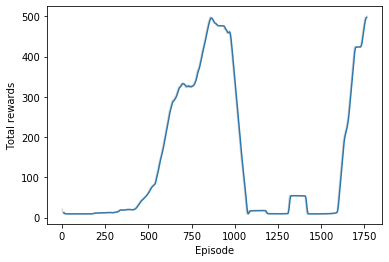

In [33]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

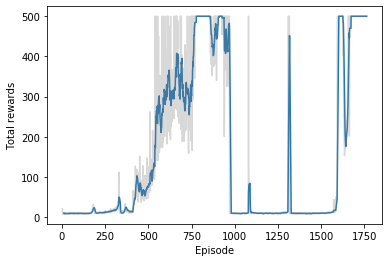

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

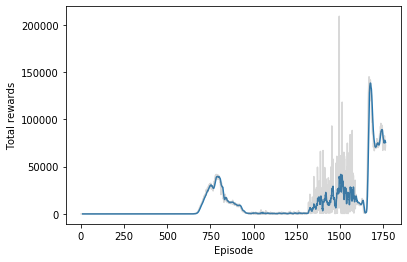

In [35]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
# Creating a gym env
import gym

# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action, _ = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))

# Close the env at the end
env.close()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.